# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import classes.file_loader as file_loader

# Data Preprocessing

## Loading Files

In [4]:
file_path = "" # File is in the parent file
file_name = "Index.xlsx"

FileLoader = file_loader.FileLoader(file_path, file_name)

In [5]:
classic_sheet_name, precarity_sheet_name = "Classique","Précarité"

classic_raw_df, preacarity_raw_df = FileLoader.load_file(classic_sheet_name, precarity_sheet_name)

In [6]:
classic_raw_df

,Date,SPOT
0,2023-04-24,7.212716
1,2023-05-01,7.321166
2,2023-05-08,7.360211
3,2023-05-15,7.380000
4,2023-05-22,7.400000
...,...,...
85,2024-12-16,7.810000
86,2024-12-23,7.970000
87,2024-12-30,7.970000
88,2025-01-06,7.970000


In [7]:
preacarity_raw_df

,Date,SPOT
0,2023-04-24,7.296783
1,2023-05-01,7.460184
2,2023-05-08,7.465385
3,2023-05-15,7.465385
4,2023-05-22,7.473191
...,...,...
85,2024-12-16,9.720000
86,2024-12-23,9.820000
87,2024-12-30,9.820000
88,2025-01-06,10.030000


## Augmented dataframes

In [8]:
augmented_classic_df = FileLoader.interpolate_dataframe(classic_raw_df)

augmented_classic_df

,Date,SPOT
0,2023-04-24,7.212716
1,2023-04-25,7.258218
2,2023-04-26,7.159060
3,2023-04-27,7.296486
4,2023-04-28,7.275243
...,...,...
446,2025-01-07,7.954354
447,2025-01-08,7.958344
448,2025-01-09,8.021391
449,2025-01-10,7.979374


In [9]:
augmented_precarity_df = FileLoader.interpolate_dataframe(preacarity_raw_df)

augmented_precarity_df

,Date,SPOT
0,2023-04-24,7.296783
1,2023-04-25,7.127488
2,2023-04-26,7.426991
3,2023-04-27,7.350771
4,2023-04-28,7.366793
...,...,...
446,2025-01-07,9.905883
447,2025-01-08,9.983044
448,2025-01-09,10.080631
449,2025-01-10,10.032681


## Plotting the augmented dataframes 

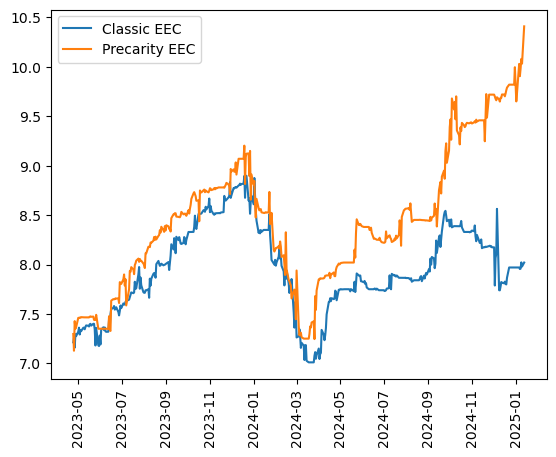

In [10]:
plt.figure()

plt.plot(augmented_classic_df["Date"], augmented_classic_df["SPOT"], label = "Classic EEC")
plt.plot(augmented_precarity_df["Date"], augmented_precarity_df["SPOT"], label = "Precarity EEC")
plt.legend()
plt.xticks(rotation = 90)

plt.show()

# Data forecasting

# Tests

From the Graph we can clearly see that the data is non stationnary. We will first differentiate the time series and check weither it has 

In [12]:
diff_classic_df = augmented_classic_df.copy()
diff_classic_df["Delta"] = diff_classic_df["SPOT"] - diff_classic_df["SPOT"].shift(1)
diff_classic_df.dropna(inplace = True)
diff_classic_df

,Date,SPOT,Delta
1,2023-04-25,7.258218,0.045501
2,2023-04-26,7.159060,-0.099158
3,2023-04-27,7.296486,0.137427
4,2023-04-28,7.275243,-0.021243
5,2023-05-01,7.321166,0.045922
...,...,...,...
446,2025-01-07,7.954354,-0.015646
447,2025-01-08,7.958344,0.003990
448,2025-01-09,8.021391,0.063048
449,2025-01-10,7.979374,-0.042018


In [13]:
diff_precarity_df = augmented_classic_df.copy()
diff_precarity_df["Delta"] = diff_precarity_df["SPOT"] - diff_precarity_df["SPOT"].shift(1)
diff_precarity_df.dropna(inplace = True)
diff_precarity_df

,Date,SPOT,Delta
1,2023-04-25,7.258218,0.045501
2,2023-04-26,7.159060,-0.099158
3,2023-04-27,7.296486,0.137427
4,2023-04-28,7.275243,-0.021243
5,2023-05-01,7.321166,0.045922
...,...,...,...
446,2025-01-07,7.954354,-0.015646
447,2025-01-08,7.958344,0.003990
448,2025-01-09,8.021391,0.063048
449,2025-01-10,7.979374,-0.042018


## ARMA

## GRU

## LSTM